# Autocorrelation
---
Here we treat a perfect pupil with no leakage
---

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
from lib.FT_modelling import *
from lib.formatter import * 
from lib.conversions import *
from scipy import signal

In [4]:
pupil = pupil_from_fits("pupil.fits")
print(pupil.shape)

(4000, 4000)


In [5]:
from astropy.io import fits 

---


In [6]:
# Define simulation parameters

aperture = 0.018 # 18mm
m2_obsc = 0 # m
wl = 525e-9 # 525nm - Central green band on RBP cam
focal_length = 0.15 # 15cm camera lens
chip_dim = 512 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
transform_size = 2**10 # 1024
x = 0 # On-axis star (pixel units)
y = 0 # On-axis star (pixel units)

## Create the model, m

In [7]:
%%time 
# Create convolution PSF
conv_PSF = FT_model(pupil, aperture, m2_obsc, 2*chip_dim, wl, focal_length, pix_size, 2*transform_size, x, y) # Convolution PSF


CPU times: user 1.08 s, sys: 203 ms, total: 1.28 s
Wall time: 1.57 s


conv_PSF shape: (1024, 1024)


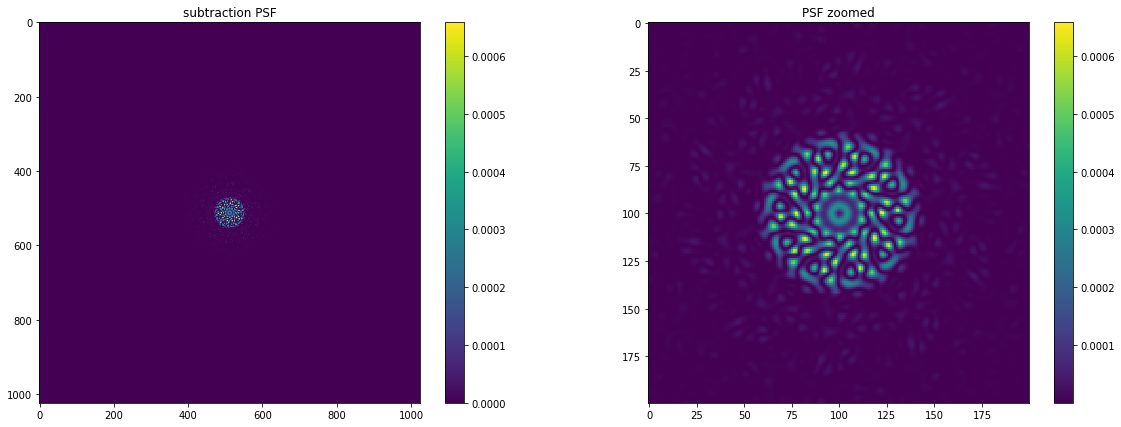

In [8]:
print("conv_PSF shape: {}".format(conv_PSF.shape))

s = 100
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(conv_PSF)
plt.title("subtraction PSF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(conv_PSF[chip_dim-s:chip_dim+s, chip_dim-s:chip_dim+s])
plt.title("PSF zoomed")
plt.colorbar()
plt.show()

fits.writeto("images/m.fits", conv_PSF, overwrite=True)
np.save("images/m.npy", conv_PSF)

d = fits.open("images/m.fits")[0].data


---

## Simulate field of stars

In [122]:
# Define image paramters

# Seeded for reporducability
np.random.seed(5)

# n_stars = 250
n_stars = [1, 10, 100, 1000]
min_flux = 1e4
max_flux = 1e6

pixel_idxs = []
positions_array = []
fluxes_array = []

for n in n_stars:
    # Generate a list of x-y coordinates in range (-chip_dim/2, chip_dim/2) as our stellar postions
    pixel_idx = (0.8*chip_dim)*(np.random.rand(2*n)).reshape([n, 2]) 
    pixel_idxs.append(pixel_idx)
    
    positions = (0.8*chip_dim)*(np.random.rand(2*n) - 0.5).reshape([n, 2])
    positions_array.append(positions)

    # Generate a list of stellar fluxes (photons) between the min and max flux values
    fluxes = min_flux + (max_flux-min_flux)*np.random.rand(n)
    fluxes_array.append(fluxes)

In [123]:
# plt.figure(figsize=(13,6))

# plt.subplot(1,2,1)
# plt.title("Stellar postions (pixels)")
# plt.scatter(positions[:,0], positions[:,1])
# plt.xlim(-chip_dim//2, chip_dim//2)
# plt.ylim(-chip_dim//2, chip_dim//2)
# plt.xlabel("x-coordinate (pixels)")
# plt.ylabel("y-coordinate (pixels)")

# plt.subplot(1,2,2)
# plt.title("Stellar fluxes")
# plt.scatter(range(n_stars), fluxes)
# plt.ylim(min_flux, max_flux)
# plt.xlabel("Star #")
# plt.ylabel("Flux (photons)")

# plt.tight_layout()
# plt.show()

---
Generate the data image, pure PSFs

In [129]:
%%time

images = []
raws = []

for i in range(len(n_stars)):

    # Create simulate and sum the different stellar positions and fluxes
    im_orig = np.zeros([chip_dim, chip_dim])
    for j in range(n_stars[i]):
        im_orig += fluxes_array[i][j]*FT_model(pupil, aperture, m2_obsc, chip_dim, wl, focal_length, pix_size, 
                                 transform_size, positions_array[i][j, 1], positions_array[i][j, 0], polar=False)
        
    # Keep a copy of the original data point
    raws.append(im_orig)
    images.append(deepcopy(im_orig))

CPU times: user 12min 23s, sys: 2min 12s, total: 14min 35s
Wall time: 15min 37s


In [131]:
padded = []

for i in range(len(n_stars)):
    # Create fully padded image
    s = chip_dim//2
    c = chip_dim
    im_pad = np.zeros([chip_dim*2, chip_dim*2])
    im_pad[c-s:c+s, c-s:c+s] = images[i]
    padded.append(im_pad)

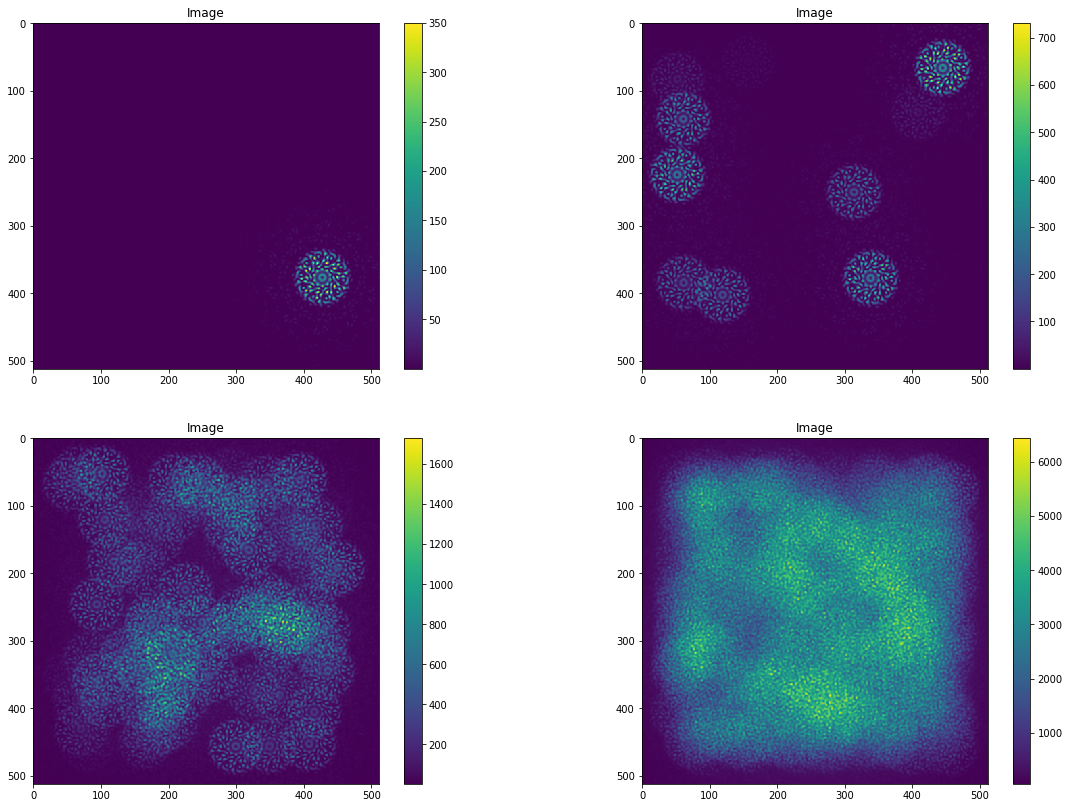

In [170]:
plt.figure(figsize=(20,(len(n_stars)/2)*7))

for n in range(len(n_stars)):

    plt.subplot((len(n_stars)/2),2,n+1)
    plt.imshow(images[n])
    plt.title("Image")
    plt.colorbar()


plt.show()

# fits.writeto("images/d.fits", im_pad, overwrite=True)
# np.save("images/d.npy", im_pad)

---


In [134]:
def convolve(arr1, arr2):
    FT1 = np.fft.fft2(arr1)
    FT2 = np.fft.fft2(arr2)
    mult = np.multiply(FT1, FT2)
    conv = np.fft.fftshift(np.fft.ifft2(mult))
    return conv

In [152]:
p = 0.01
scale = 1e4
ps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

In [154]:
Ks_mags = []
for n in range(len(n_stars)):

    K_mags = []
    for p in ps:
        M = np.fft.fft2(conv_PSF) # M
        M_conj = np.conj(M) # M*
        D = np.fft.fft2(padded[n]) # D

        numer = np.multiply(D, M_conj) # D.M*
        denom = np.multiply(M, M_conj) # M.M*


        h = np.hamming(2)
        h2d = np.sqrt(np.outer(h,h))
        ham2d = np.zeros([2*chip_dim, 2*chip_dim])
        ham2d[:2, :2] = h2d

        numer_out = convolve(numer, ham2d)
        denom_out = convolve(denom, ham2d)

        sig = p*np.max(denom_out)
        denom_out += sig

        div = np.divide(numer_out, denom_out)

        K = np.fft.fftshift(np.fft.ifft2(div))
        K_mag = np.abs(K)
        K_mag = scale*K_mag/np.sum(K_mag)

        K_mags.append(K_mag)
        
    Ks_mags.append(K_mags)


In [180]:
# n = 3
# plt.figure(figsize=(20,len(ps)*7))

# for i in range(len(ps)):

#     plt.subplot(len(ps), 2, 2*i+1)
#     plt.imshow(Ks_mags[n][i][c-s:c+s, c-s:c+s], cmap='gray')
#     plt.title("{}: {}".format(i, np.log10(ps[i])))
#     plt.colorbar()

#     plt.subplot(len(ps), 2, 2*i+2)
#     plt.title("{}: {}".format(i, np.log10(ps[i])))
#     plt.imshow(Ks_mags[n][i][c-s:c+s, c-s:c+s]**0.5, cmap='gray')
#     plt.colorbar()


# plt.show()

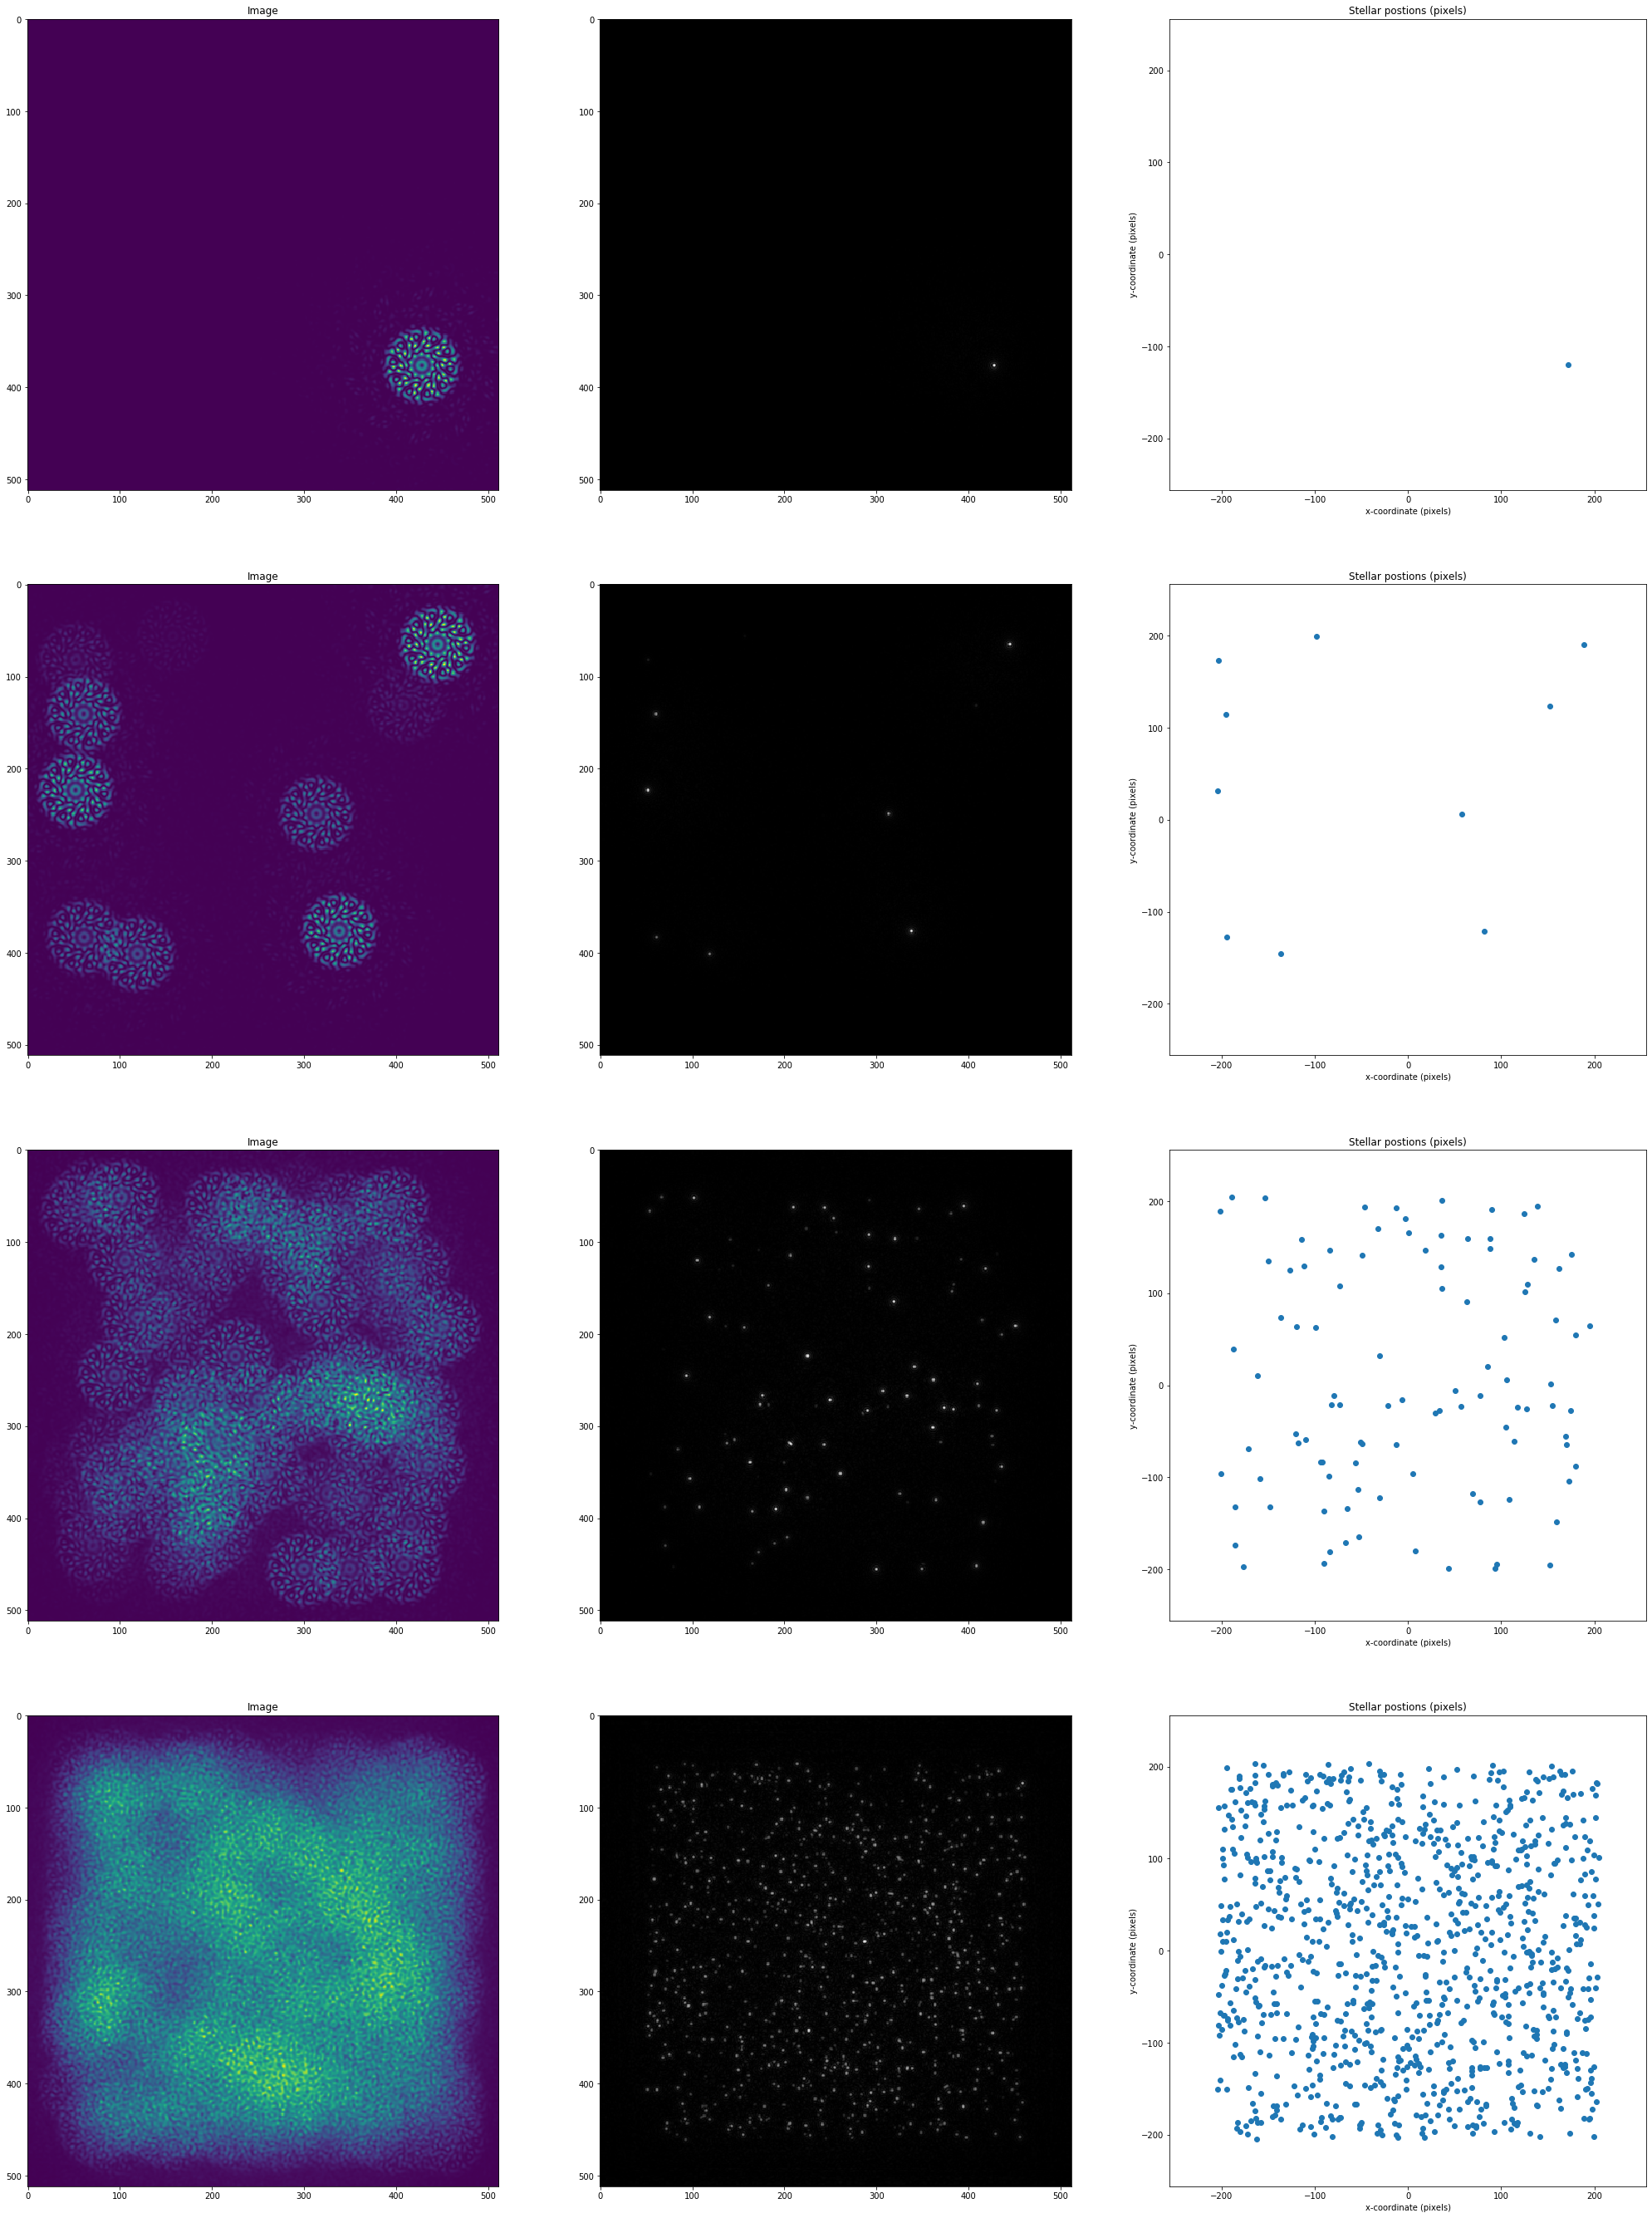

In [186]:
# plt.figure(figsize=(30,len(n_stars)*15))
plt.figure(figsize=(35,len(n_stars)*12))
i = 2
j = 1
for n in range(len(n_stars)):
    /usr/bin/env: ‘node’: No such file or directory
    plt.subplot(len(n_stars), 3, j)
    plt.imshow(images[n])
    plt.title("Image")
#     plt.colorbar()

    plt.subplot(len(n_stars), 3, j+1)
    plt.imshow(Ks_mags[n][i][c-s:c+s, c-s:c+s], cmap='gray')
    # plt.imshow(Ks_mags[n][i][c-s:c+s, c-s:c+s]**0.5, cmap='gray')

    plt.subplot(len(n_stars), 3, j+2)
    plt.title("Stellar postions (pixels)")
    plt.scatter(positions_array[n][:,1], positions_array[n][:,0])
    plt.xlim(-chip_dim//2, chip_dim//2)
    plt.ylim(-chip_dim//2, chip_dim//2)
    plt.xlabel("x-coordinate (pixels)")
    plt.ylabel("y-coordinate (pixels)")
    
    j += 3

plt.show()

In [15]:
M = np.fft.fft2(conv_PSF) # M
M_conj = np.conj(M) # M*
D = np.fft.fft2(im_pad) # D

numer = np.multiply(D, M_conj) # D.M*
denom = np.multiply(M, M_conj) # M.M*

n = 1024
h = np.hamming(n)
h2d = np.sqrt(np.outer(h,h))
ham2d = np.zeros([2*chip_dim, 2*chip_dim])
ham2d[:n, :n] = h2d

numer_re = np.real(numer)
numer_im = np.imag(numer)
denom_re = np.real(denom)
denom_im = np.imag(denom)

numer_re_conv = np.multiply(numer_re, ham2d)
numer_im_conv = np.multiply(numer_im, ham2d)
denom_re_conv = np.multiply(denom_re, ham2d)
denom_im_conv = np.multiply(denom_im, ham2d)

numer_out = numer_re_conv + 1j*numer_im_conv
denom_out = denom_re_conv + 1j*denom_im_conv

# h = np.hamming(len(M))
# ham2d = np.sqrt(np.outer(h,h))

# numer_out = np.multiply(numer, zeros)
# denom_out = np.multiply(denom, zeros)

sig = 0.001*np.max(denom_out)
denom_out += sig

div1 = np.divide(numer_out, denom_out)

K1 = np.fft.fftshift(np.fft.ifft2(div1))

In [22]:
M = np.fft.fft2(conv_PSF) # M
M_conj = np.conj(M) # M*
D = np.fft.fft2(im_pad) # D

numer = np.multiply(D, M_conj) # D.M*
denom = np.multiply(M, M_conj) # M.M*

n = 2
h = np.hamming(n)
h2d = np.sqrt(np.outer(h,h))
ham2d = np.zeros([2*chip_dim, 2*chip_dim])
ham2d[:n, :n] = h2d

numer_out = convolve(numer, ham2d)
denom_out = convolve(denom, ham2d)

# h = np.hamming(len(M))
# ham2d = np.sqrt(np.outer(h,h))

# numer_out = np.multiply(numer, zeros)
# denom_out = np.multiply(denom, zeros)

sig = 0.001*np.max(denom_out)
denom_out += sig

div2 = np.divide(numer_out, denom_out)

K2 = np.fft.fftshift(np.fft.ifft2(div2))

In [28]:
K1_norm = 1e6*np.abs(K1)/np.sum(np.abs(K1))
K2_norm = 1e6*np.abs(K2)/np.sum(np.abs(K2))

print(np.sum(K1_norm))
print(np.sum(K2_norm))

1000000.0
999999.9999999999


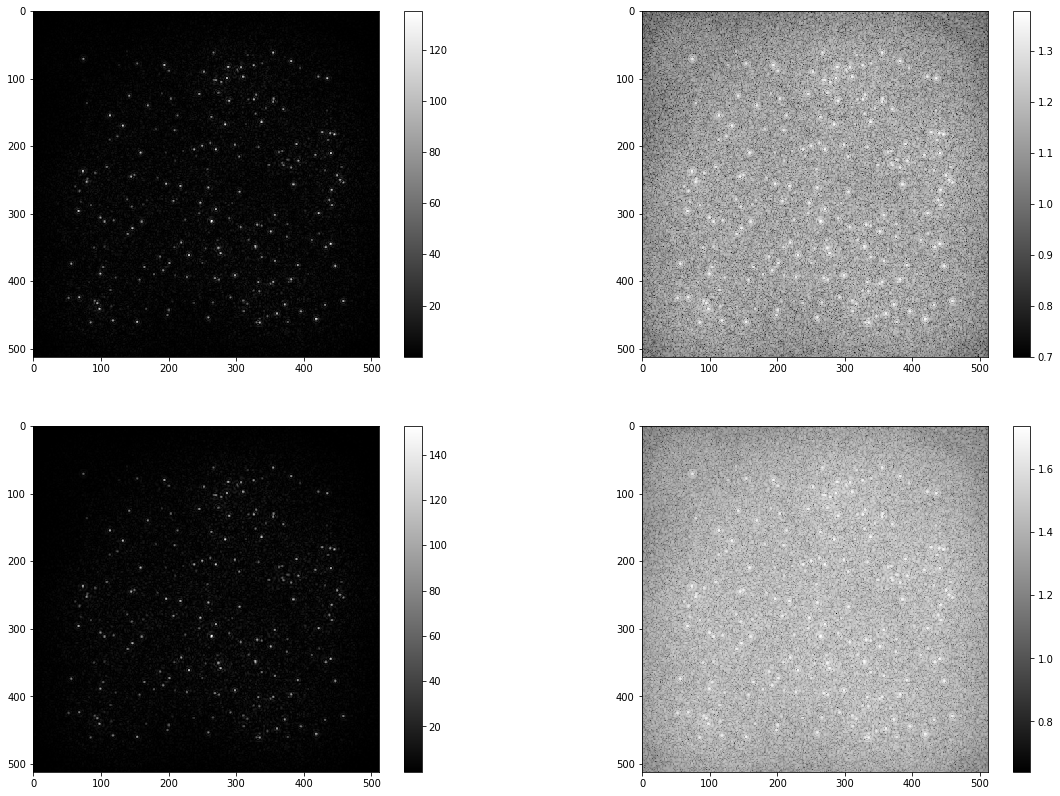

In [30]:
plt.figure(figsize=(20,14))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(K1_norm[c-s:c+s, c-s:c+s]), cmap='gray')
# plt.imshow(np.abs(K))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(np.abs(K1[c-s:c+s, c-s:c+s])**0.05, cmap='gray')
# plt.imshow(np.abs(K)**0.5)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(np.abs(K2_norm[c-s:c+s, c-s:c+s]), cmap='gray')
# plt.imshow(np.abs(K))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.abs(K2[c-s:c+s, c-s:c+s])**0.05, cmap='gray')
# plt.imshow(np.abs(K)**0.5)
plt.colorbar()

plt.show()

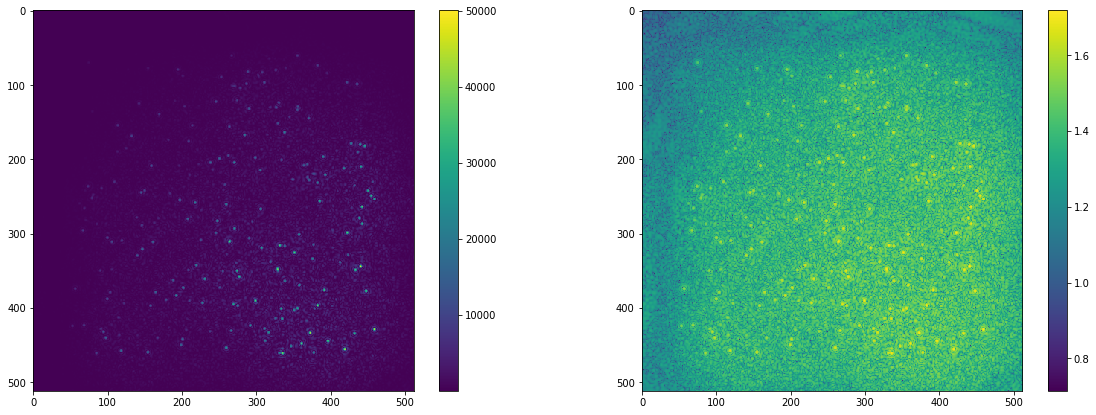

In [27]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(K[:chip_dim, :chip_dim]))
# plt.imshow(np.abs(K))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.abs(K[:chip_dim, :chip_dim])**0.05)
# plt.imshow(np.abs(K)**0.5)
plt.colorbar()

plt.show()

In [15]:
# # %%time

# FT_M = np.fft.fft2(conv_PSF) # M
# fits.writeto("images/M_Re.fits", np.real(FT_M), overwrite=True)
# fits.writeto("images/M_Im.fits", np.imag(FT_M), overwrite=True)

# FT_M_conj = np.conj(FT_M) # M*
# fits.writeto("images/M_star_Re.fits", np.real(FT_M_conj), overwrite=True)
# fits.writeto("images/M_star_Im.fits", np.imag(FT_M_conj), overwrite=True)

# FT_D = np.fft.fft2(im_pad) # D
# fits.writeto("images/D_Re.fits", np.real(FT_D), overwrite=True)
# fits.writeto("images/D_Im.fits", np.real(FT_D), overwrite=True)

# # numer = np.abs(np.multiply(FT_D, FT_M_conj))
# # denom = np.abs(np.multiply(FT_M, FT_M_conj))

# numer = np.multiply(FT_D, FT_M_conj) # D.M*
# fits.writeto("images/D_M_star_Re.fits", np.real(numer), overwrite=True)
# fits.writeto("images/D_M_star_Im.fits", np.imag(numer), overwrite=True)

# denom = np.multiply(FT_M, FT_M_conj) # M.M*
# fits.writeto("images/M_M_star_Re.fits", np.real(denom), overwrite=True)
# fits.writeto("images/M_M_star_Im.fits", np.imag(denom), overwrite=True)

# numer_FT = np.fft.fft2(numer)
# denom_FT = np.fft.fft2(denom)

# ### Blurring function

# c = numer.shape[0]//2
# s = 2

# # High or low pass filter #1

# zeros = np.zeros([s, s], dtype=np.complex)
# window = np.ones([2*chip_dim, 2*chip_dim], dtype=np.complex)
# window[:s,:s] = zeros
# window[-s:,:s] = zeros
# window[:s,-s:] = zeros
# window[-s:,-s:] = zeros

# # High or low pass filter #2

# # zeros = np.zeros([2*s, 2*s], dtype=np.complex)
# # window = np.ones([2*chip_dim, 2*chip_dim], dtype=np.complex)
# # window[c-s:c+s, c-s:c+s] = zeros

# ### Blurring function

# ### Apply blurring function

# numer_windowed = np.multiply(numer_FT, window)
# denom_windowed = np.multiply(denom_FT, window)

# ###

# numer_out = np.fft.ifft2(numer_windowed)
# fits.writeto("images/blured_D_M_star_Re.fits", np.real(numer_out), overwrite=True)
# fits.writeto("images/blured_D_M_star_Im.fits", np.imag(numer_out), overwrite=True)

# denom_out = np.fft.ifft2(denom_windowed)
# fits.writeto("images/blured_M_M_star_Re.fits", np.real(denom_out), overwrite=True)
# fits.writeto("images/blured_M_M_star_Im.fits", np.imag(denom_out), overwrite=True)

# # numer_blur = np.zeros(numer.shape)
# # denom_out = np.zeros(denom.shape)



# # # for i in range(conv_PSF.shape[0]):
# # #     for j in range(conv_PSF.shape[0]):
# # #         numer_out[i][j] = (numer[i-1][j] + numer[(i+1)%conv_PSF.shape[0]][j] + numer[i][j-1] + numer[i][(j+1)%conv_PSF.shape[1]])/4
# # #         denom_out[i][j] = (denom[i-1][j] + denom[(i+1)%conv_PSF.shape[0]][j] + denom[i][j-1] + denom[i][(j+1)%conv_PSF.shape[1]])/4
# #         numer_out[i][j] = (numer[i][j] + numer[(i+1)%(1024)][j] + numer[i][(j+1)%(1024)] + numer[(i+1)%(1024)][(j+1)%(1024)])/4
# #         denom_out[i][j] = (denom[i][j] + denom[(i+1)%(1024)][j] + denom[i][(j+1)%(1024)] + denom[(i+1)%(1024)][(j+1)%(1024)])/4


# sig = (np.max(denom_out)/1000)*np.ones(denom.shape)
# denom_out_const = denom_out + sig
# fits.writeto("images/blured_M_M_star_plus_const_Re.fits", np.real(denom_out_const), overwrite=True)
# fits.writeto("images/blured_M_M_star_plus_const_Im.fits", np.imag(denom_out_const), overwrite=True)

# div = np.divide(numer_out, denom_out_const)
# fits.writeto("images/divideds_Re.fits", np.real(div), overwrite=True)
# fits.writeto("images/divideds_Im.fits", np.imag(div), overwrite=True)

# K = np.fft.fftshift(np.fft.ifft2(div))
# fits.writeto("images/K_Re.fits", np.real(K), overwrite=True)
# fits.writeto("images/K_Im.fits", np.imag(K), overwrite=True)

In [ ]:
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
plt.imshow(np.log(np.abs(FT_M)))
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.angle(FT_M))
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow((np.abs(FT_D)**0.5), cmap="gray")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.angle(FT_D), cmap='gray')
plt.colorbar()

plt.show()

In [ ]:
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
plt.imshow(np.log(np.abs(numer)))
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.angle(numer))
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(denom)))
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.angle(denom))
plt.colorbar()

plt.show()

In [ ]:
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
plt.imshow(np.log(np.abs(numer_out)))
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.angle(numer_out))
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(denom_out)))
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.angle(denom_out))
plt.colorbar()

plt.show()

In [ ]:
plt.figure(figsize=(20,7))

div_shift = np.fft.fftshift(div)

plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(div_shift)), cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.angle(div_shift))
plt.colorbar()

plt.show()

In [ ]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(np.abs(corr)**0.5, cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.angle(corr))
plt.colorbar()

plt.show()

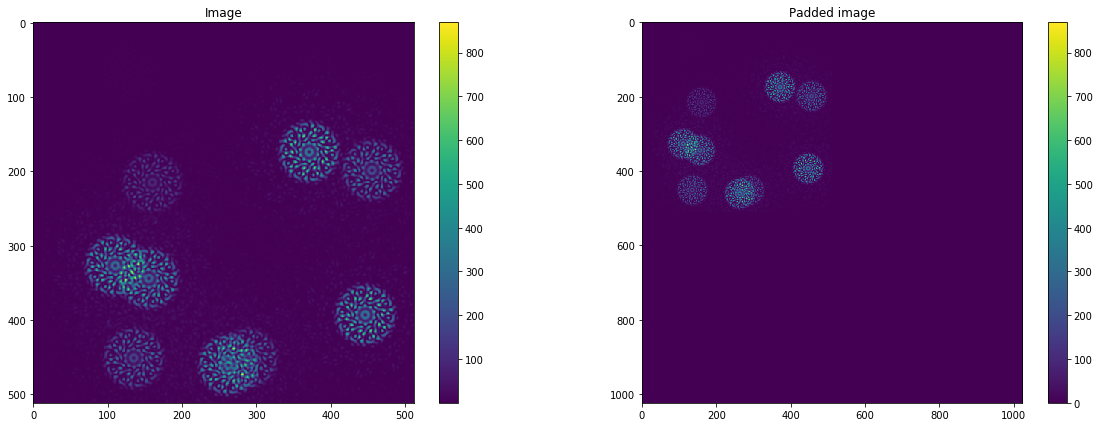

In [130]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(im)
plt.title("Image")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(im_pad)
plt.title("Padded image")
plt.colorbar()

plt.show()

In [19]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(denom)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.log(denom))
plt.colorbar()

plt.show()

print(np.min(denom))

In [20]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(denom_out)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.log(denom_out))
plt.colorbar()

plt.show()

print(np.min(denom_out))

In [21]:

corr = np.fft.fftshift(np.fft.ifft2(div))

# corr = np.fft.ifft2(div)

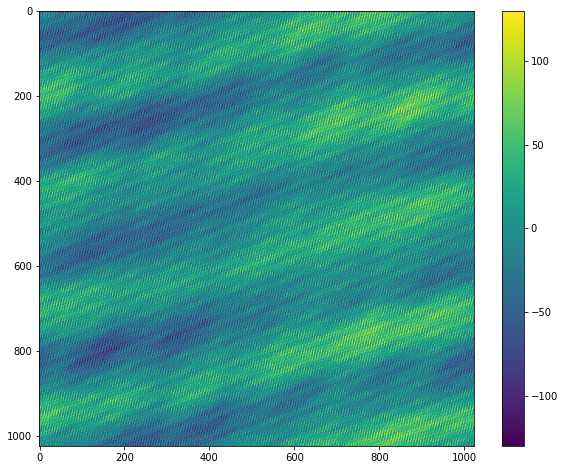

In [27]:
plt.figure(figsize=(10,8))
# plt.imshow(np.log(np.imag(corr)))
plt.imshow(np.imag(corr))
plt.colorbar()
plt.show()

---
## Apply the Kieran correlation

Imaginary component seems to how no information (and magnitude array is identical to real array)

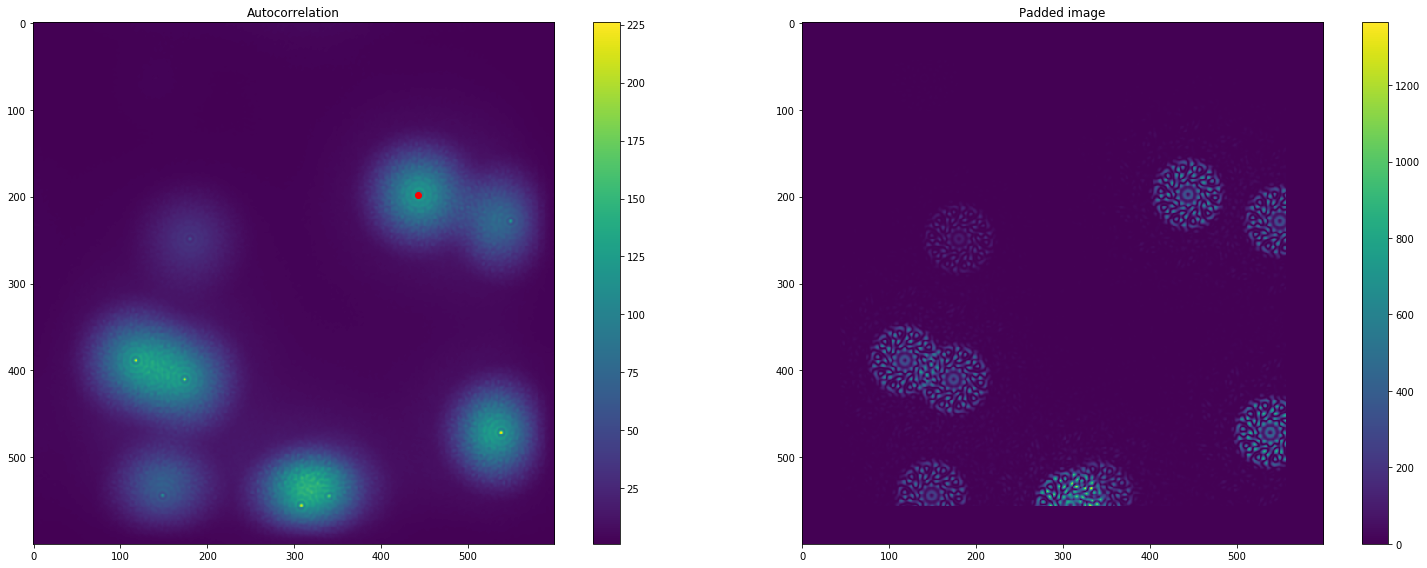

In [22]:
# plt.figure(figsize=(15,12))
plt.figure(figsize=(22,8))

plt.subplot(1, 2, 1)
# plt.subplot(2, 2, 1)
plt.imshow(correlation)
plt.colorbar()
plt.title("Autocorrelation")
plt.scatter(idx[1], idx[0], color='r')

plt.subplot(1, 2, 2)
# plt.subplot(2, 2, 2)
plt.imshow(im_pad)
plt.colorbar()
plt.title("Padded image")

# plt.subplot(1, 2, 2)
# # plt.subplot(2, 2, 2)
# plt.imshow(imag)
# plt.colorbar()
# plt.title("Imaginary")

# plt.subplot(2, 2, 3)
# plt.imshow(mag)
# plt.colorbar()
# plt.title("Magnitude")

# plt.subplot(2, 2, 4)
# plt.imshow(phase)
# plt.colorbar()
# plt.title("Phase")

plt.tight_layout()
plt.show()

---
Begin image subraction

In [211]:
sub_PSF.shape

(1024, 1024)

In [238]:
# %%time

stars = []
i = 0
fft_PSF = np.fft.fft2(conv_PSF)
im = deepcopy(im_orig)

while np.max(im) > 200:
# for i in range(10):
    
    # Pad the array from the image
    im_pad[pad_pix:chip_dim+pad_pix, pad_pix:chip_dim+pad_pix] = im
    
#     print(im.shape)
#     print(im_pad.shape)
    
    # Autocorrelate the padded image
    fft_im = np.fft.fft2(im_pad)
    mult = np.multiply(fft_PSF, fft_im)
    conv = np.fft.fftshift(np.fft.ifft2(mult))
    correlation = np.real(conv)[pad_pix:-pad_pix, pad_pix:-pad_pix]
    
#     print(correlation.shape)
    
    # Find the peak correlation value
    maxes = np.where(correlation == np.max(correlation))
    idx = np.array(maxes).reshape(2) 
#     pos = np.array([idx[1]-(pad_pix+chip_dim//2), (pad_pix+chip_dim//2)-idx[0]])
    pos = np.array([idx[1]-(chip_dim//2), (chip_dim//2)-idx[0]])
    
#     print(idx)
#     print(pos)
    
    
    
    # Find magnitude of brightest pixel 
    # Window a region the size of the psf around the star
    peak_flux = np.max(im_pad[idx[0]-size_PSF:idx[0]+size_PSF, idx[1]-size_PSF:idx[1]+size_PSF])
    
#     print(peak_flux)

#     print(chip_dim-idx[0], 2*chip_dim-idx[0])
#     print(chip_dim-idx[1], 2*chip_dim-idx[1])
    
    # Contrstucuct a mask to center the subtraction PSF on the image PSF
    sub_PSF_masked = sub_PSF[chip_dim - idx[0]: 2*chip_dim - idx[0], chip_dim - idx[1]: 2*chip_dim - idx[1]]
    
    #[chip_dim-idx[0]:2*chip_dim-idx[0], chip_dim-idx[1]:2*chip_dim-idx[1]]
    
    #[(chip_dim//2) - pad_pix - idx[0] : 2*(chip_dim//2) - pad_pix - idx[0], (chip_dim//2) - pad_pix - idx[1] : 2*(chip_dim//2) - pad_pix - idx[1]]
    
#     [chip_dim-idx[0]:2*chip_dim-idx[0], chip_dim-idx[1]:2*chip_dim-idx[1]]
    
#     print(sub_PSF_masked.shape)
    
    # Normalise to a peak pixel value of 1
    sub_PSF_norm = sub_PSF_masked/np.max(sub_PSF_masked)
    
    # Scale to 5% the peak flux 
    sub_PSF_scaled = 0.5*peak_flux*sub_PSF_norm
    
    # Subtract the PSF from the image
    im -= sub_PSF_scaled
    
    # Add the subracted flux to the list
    stars.append([pos, np.sum(sub_im_scaled)])
    
    i += 1
    
    
# # for i in range(1):
    
#     # Find brighest star position
#     maxes = np.where(real == np.max(real))
#     idx = np.array(maxes).reshape(2) 
#     pos = np.array([idx[1]-(pad_pix+chip_dim//2), (pad_pix+chip_dim//2)-idx[0]])
    
#     # Find magnitude of brightest pixel 
#     # Window a region the size of the psf around the star
#     peak_flux = np.max(im_pad[idx[0]-size_PSF:idx[0]+size_PSF, idx[1]-size_PSF:idx[1]+size_PSF])
    
#     # Contrstucuct a mask to center the subtraction PSF on the image PSF
#     sub_im_masked = sub_im[sub_c-idx[0]:2*sub_c-idx[0], sub_c-idx[1]:2*sub_c-idx[1]]
    
#     # Normalise to a peak pixel value of 1
#     sub_im_norm = sub_im_masked/np.max(sub_im_masked)
    
#     # Scale to 5% the peak flux 
#     sub_im_scaled = 0.5*peak_flux*sub_im_norm
    
#     # Subtract the PSF from the image
#     im_pad -= sub_im_scaled
    
#     # Add the subracted flux to the list
#     stars.append([pos, np.sum(sub_im_scaled)])
    
#     # Re-autocorrelate the image
#     fft_im = np.fft.fft2(im_pad)
#     mult = np.multiply(fft_PSF, fft_im)
#     conv = np.fft.fftshift(np.fft.ifft2(mult))
#     real = np.real(conv)

#     i += 1

In [228]:
print(idx[0]-size_PSF,idx[0]+size_PSF)
print(idx[1]-size_PSF,idx[1]+size_PSF)

-19 59
57 135


In [239]:
i

35

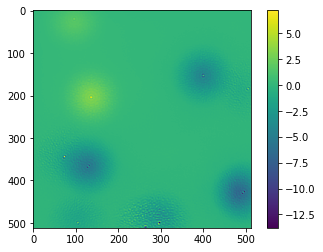

In [240]:
plt.imshow(correlation)
plt.colorbar()

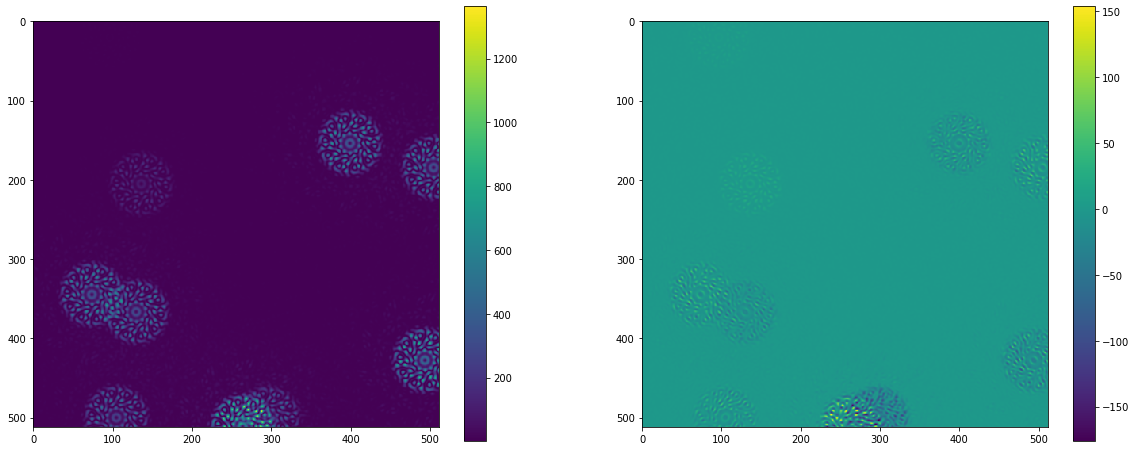

In [241]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.imshow(im_orig)
plt.colorbar()
# plt.scatter(idx[1], idx[0], color='r')

plt.subplot(1,2,2)
plt.imshow(im)
plt.colorbar()
# plt.scatter(idx[1], idx[0], color='r')

plt.show()

In [ ]:
mask = im_pad[im_pad < 0]

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.imshow(im_pad)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(im)
plt.colorbar()

plt.show()

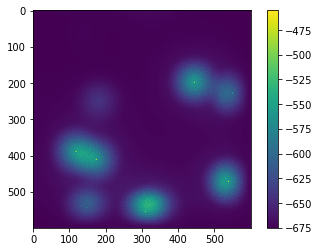

In [143]:
fft_im = np.fft.fft2(im_pad)
mult = np.multiply(fft_PSF, fft_im)
conv = np.fft.fftshift(np.fft.ifft2(mult))
real = np.real(conv)
plt.imshow(real)
plt.colorbar()